In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.svm import SVR
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.spatial.distance import mahalanobis

In [2]:
weather_all = pd.read_csv("/workspaces/13-Weather-Forecast/Tan - Random Forest/hanoiweather.csv")

In [3]:
from datetime import datetime

def time_to_minutes(time_str):
    # Định nghĩa các định dạng thời gian khác nhau
    formats = ["%Y-%m-%dT%H:%M:%S", "%Y-%m-%d %H:%M:%S"]
    
    for fmt in formats:
        try:
            # Cố gắng phân tích chuỗi thời gian với từng định dạng
            time_obj = datetime.strptime(time_str, fmt)
            return time_obj.hour * 60 + time_obj.minute
        except ValueError:
            # Nếu định dạng không khớp, thử định dạng tiếp theo
            continue
    
    # Nếu không có định dạng nào khớp, in lỗi
    raise ValueError(f"Thời gian '{time_str}' không khớp với bất kỳ định dạng nào đã biết")

# Biến đổi thời gian của sunrise và sunset
weather_all['sunrise_minutes'] = weather_all['sunrise'].apply(time_to_minutes)
weather_all['sunset_minutes'] = weather_all['sunset'].apply(time_to_minutes)

In [4]:
weather_all

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,sunrise_minutes,sunset_minutes
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,NaN,1990-01-01T06:33:41,1990-01-01T17:26:18,0.14,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,393,1046
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,NaN,1990-01-02T06:34:00,1990-01-02T17:26:56,0.18,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1046
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,NaN,1990-01-03T06:34:18,1990-01-03T17:27:34,0.22,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1047
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,NaN,1990-01-04T06:34:35,1990-01-04T17:28:12,0.25,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,NaN,1990-01-05T06:34:51,1990-01-05T17:28:51,0.29,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12550,Hà Nội,2024-05-12,34.0,24.6,28.5,43.5,24.6,33.1,25.5,84.8,...,60.0,2024-05-12T05:20:10,2024-05-12T18:26:03,0.13,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"48820099999,48823099999,48825099999,4883109999...",320,1106
12551,Hà Nội,2024-05-13,30.1,23.0,26.7,33.9,23.0,28.5,22.9,80.9,...,10.0,2024-05-13T05:19:44,2024-05-13T18:26:28,0.16,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999...",319,1106
12552,Hà Nội,2024-05-14,32.0,24.0,28.0,37.8,24.0,31.0,23.8,78.7,...,30.0,2024-05-14T05:19:18,2024-05-14T18:26:54,0.20,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999...",319,1106
12553,Hà Nội,2024-05-15,31.0,24.0,27.4,39.0,24.0,30.5,25.0,87.7,...,30.0,2024-05-15T05:18:54,2024-05-15T18:27:19,0.25,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,VVNB,318,1107


In [5]:
# Tạo cột mới có giá trị là nhiệt độ cao nhất của ngày hôm sau 
weather_all['tempmax_next'] = weather_all['tempmax'].shift(-1)
weather_all = weather_all.ffill()

In [6]:
weather_all.set_index('datetime',inplace = True)
weather_all.index = pd.to_datetime(weather_all.index)

In [7]:
weather_all

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sunrise,sunset,moonphase,conditions,description,icon,stations,sunrise_minutes,sunset_minutes,tempmax_next
datetime,,,,,,,,,,,,,,,,,,,,,
1990-01-01,Hà Nội,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,NaN,...,1990-01-01T06:33:41,1990-01-01T17:26:18,0.14,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,393,1046,17.4
1990-01-02,Hà Nội,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,NaN,...,1990-01-02T06:34:00,1990-01-02T17:26:56,0.18,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1046,18.2
1990-01-03,Hà Nội,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,NaN,...,1990-01-03T06:34:18,1990-01-03T17:27:34,0.22,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1047,19.6
1990-01-04,Hà Nội,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,NaN,...,1990-01-04T06:34:35,1990-01-04T17:28:12,0.25,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048,18.1
1990-01-05,Hà Nội,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,NaN,...,1990-01-05T06:34:51,1990-01-05T17:28:51,0.29,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-12,Hà Nội,34.0,24.6,28.5,43.5,24.6,33.1,25.5,84.8,17.168,...,2024-05-12T05:20:10,2024-05-12T18:26:03,0.13,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"48820099999,48823099999,48825099999,4883109999...",320,1106,30.1
2024-05-13,Hà Nội,30.1,23.0,26.7,33.9,23.0,28.5,22.9,80.9,142.584,...,2024-05-13T05:19:44,2024-05-13T18:26:28,0.16,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999...",319,1106,32.0
2024-05-14,Hà Nội,32.0,24.0,28.0,37.8,24.0,31.0,23.8,78.7,0.900,...,2024-05-14T05:19:18,2024-05-14T18:26:54,0.20,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999...",319,1106,31.0


In [8]:
# Lựa chọn các loại đặc trưng độ ẩm, lớp phủ mây, tốc độ gió,  áp suất mực nước biển
features = ['tempmax', 'tempmin', 'temp']
weather = weather_all[features]
label = weather_all['tempmax_next']

In [9]:
weather.head(5)

,tempmax,tempmin,temp
datetime,,,
1990-01-01,15.9,13.4,14.6
1990-01-02,17.4,14.6,16.1
1990-01-03,18.2,16.1,16.8
1990-01-04,19.6,15.2,16.4
1990-01-05,18.1,15.4,16.9


In [10]:
def entropy(s):
    values, counts = np.unique(s, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [11]:
tempmax_entropy = entropy(weather['tempmax'])
print("Entropy of tempmax:", tempmax_entropy)

Entropy of tempmax: 7.008713875140045


In [12]:
weather = weather_all[features]
label = weather_all['tempmax_next']

In [14]:
valid_columns = weather.columns[weather.isnull().sum() < 57]

In [15]:
# Phân chia tập dữ liệu
from sklearn.model_selection import train_test_split
X = weather[:'2024-04-30']
y = label[:'2024-04-30']
X_test = weather['2024-05-01':]
y_test = label['2024-05-01':]
X_train = X[:'2017-12-31']
y_train = y[:'2017-12-31']
X_val = X['2018-01-01':]
y_val = y['2018-01-01':]
print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm thử:", X_val.shape, y_val.shape)

Kích thước tập huấn luyện: (10227, 3) (10227,)
Kích thước tập kiểm thử: (2312, 3) (2312,)


BASE LINE tempmax_n+1 = tempmax_n

In [16]:
print("mean_absolute_error:",mean_absolute_error(y_val,X_val['tempmax']))
print("mean_squared_error:",mean_squared_error(y_val,X_val['tempmax']))
print("mean_absolute_percentage_error:",mean_absolute_percentage_error(y_val,X_val['tempmax']))

mean_absolute_error: 1.8878892733564014
mean_squared_error: 6.698754325259515
mean_absolute_percentage_error: 0.07322222296324836


In [17]:
def mahalanobis_kernel(X, Y=None, V=None):
    if V is None:
        V = np.cov(X.T)  # Compute the covariance matrix of the dataset
    VI = np.linalg.inv(V)  # Inverse of the covariance matrix

    def mahalanobis_distance(x, y):
        return mahalanobis(x, y, VI)

    if Y is None:
        Y = X

    K = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            K[i, j] = np.exp(-mahalanobis_distance(x, y))

    return K


In [18]:
from sklearn.base import BaseEstimator, RegressorMixin

class MahalanobisSVR(BaseEstimator, RegressorMixin):
    def __init__(self, epsilon=0.1, gamma = 0.1):
        self.epsilon = epsilon
        self.gamma = gamma
        self.V_ = None
        self.svr_ = None

    def fit(self, X, y):
        # Ensure X is a 2D array with shape (n_samples, n_features)
        X = np.atleast_2d(X)
        self.V_ = np.cov(X.T)  # Store the covariance matrix during fitting
        K = mahalanobis_kernel(X, V=self.V_)
        self.svr_ = SVR(epsilon=self.epsilon,gamma=self.gamma,kernel='precomputed')
        self.svr_.fit(K, y)
        self.X_fit_ = X
        return self

    def predict(self, X):
        # Ensure X is a 2D array with shape (n_samples, n_features)
        X = np.atleast_2d(X)
        K = mahalanobis_kernel(X, self.X_fit_, V=self.V_)
        return self.svr_.predict(K)


In [19]:
X_train

,tempmax,tempmin,temp
datetime,,,
1990-01-01,15.9,13.4,14.6
1990-01-02,17.4,14.6,16.1
1990-01-03,18.2,16.1,16.8
1990-01-04,19.6,15.2,16.4
1990-01-05,18.1,15.4,16.9
...,...,...,...
2017-12-27,17.0,14.0,15.2
2017-12-28,18.2,14.0,16.0
2017-12-29,19.2,16.0,17.7


In [21]:
mahalanobis_svr = MahalanobisSVR(epsilon=0.1,gamma = 0.1)
mahalanobis_svr.fit(X_train, y_train)

MahalanobisSVR()

In [22]:
# Predict on the val set
y_pred = mahalanobis_svr.predict(X_val)

ValueError: Found input variables with inconsistent numbers of samples: [16, 2312]

In [23]:
mape = mean_absolute_percentage_error(y_val, y_pred)
mae = mean_absolute_error(y_val,y_pred)
mse = mean_squared_error(y_val,y_pred)

In [24]:
print(mape)
print(mae)
print(mse)

0.07170282458669604
1.8411209941225897
6.026884699765919


In [25]:
y_pred

array([20.13808621, 19.52532922, 22.87855793, ..., 34.51754924,
       33.2656128 , 35.56734624])

In [26]:
mahalanobis_svr.fit(X,y)

MahalanobisSVR()

In [29]:
forecast = mahalanobis_svr.predict(X_test)

In [30]:
forecast

array([29.60972513, 27.40779158, 28.87223638, 33.40004877, 30.43775024,
       29.3026986 , 31.15526425, 31.90003724, 31.14015576, 32.06690859,
       32.92191234, 32.46560552, 30.63852379, 31.71905277, 31.35040485,
       29.58402871])

In [31]:
mape = mean_absolute_percentage_error(y_test, forecast)
mae = mean_absolute_error(y_test,forecast)
mse = mean_squared_error(y_test,forecast)
print(mape)
print(mae)
print(mse)

0.054481014127023206
1.6314770647924313
4.390548445143311


<Axes: xlabel='datetime'>

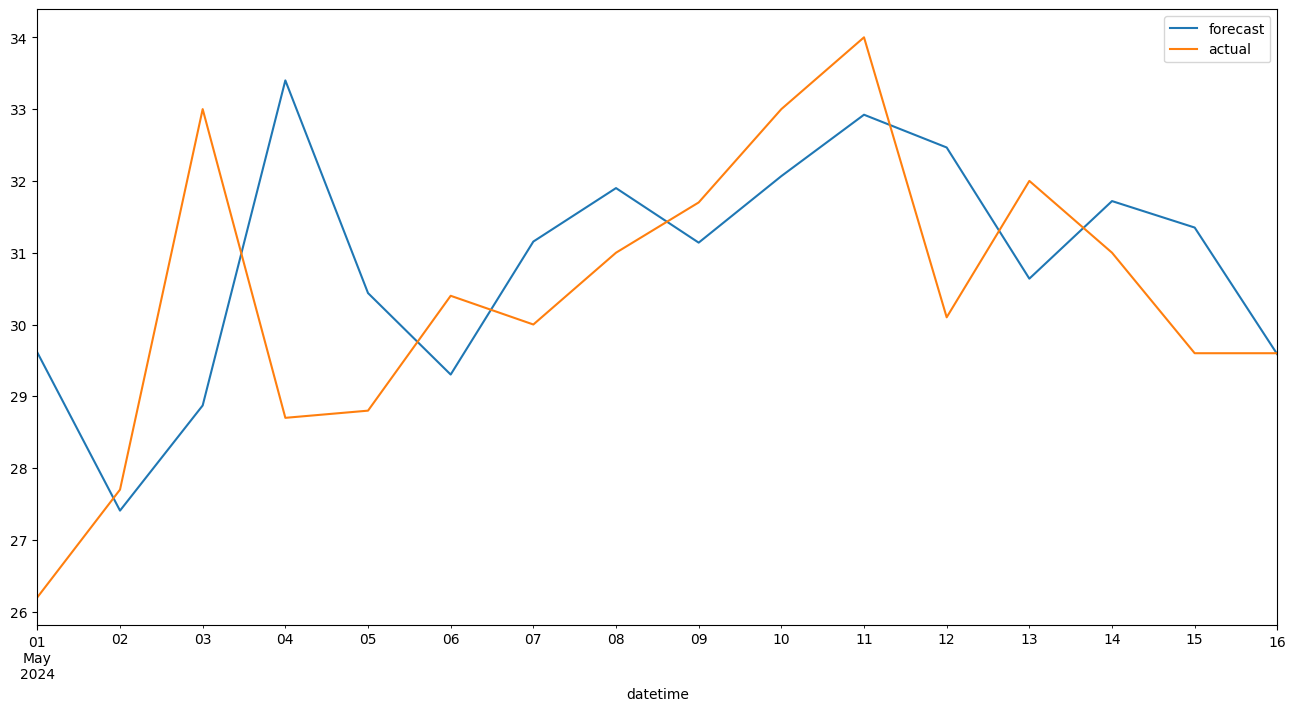

In [32]:
data = {
    'forecast':forecast,
    'actual': y_test,
}

combined = pd.DataFrame(data)
combined.plot(figsize=(16,8))